In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# state = North Dakota
state_ab = "nd"

## Data
1. Download all the data in directory "nd_data"
2. Extract them all

In [5]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
send_data = "./{}{}_sldu_adopted_2021/nd_sldu_adopted_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_adopted_2021/FinalShape1282021 2021-12-08.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [6]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 10):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [7]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [8]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [9]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [10]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [11]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [12]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [13]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [15]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [16]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [17]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [18]:
maup.doctor(population_df)

100%|███████████████████████████████████| 84566/84566 [00:27<00:00, 3047.01it/s]


True

In [19]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [20]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [21]:
population_df.rename(columns=rename_dict, inplace = True)

In [22]:
county_df = county_df.to_crs(county_df.estimate_utm_crs())
maup.doctor(county_df)

100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 487.63it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [25]:
vest20 = gpd.read_file(vest20_data)

In [26]:
vest20.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREOWRI', 'G20HALRARM', 'G20HALDRAK', 'G20HALLPET',
       'G20HALOWRI', 'G20GOVRBUR', 'G20GOVDLEN', 'G20GOVLHEN', 'G20GOVOWRI',
       'G20AUDRGAL', 'G20AUDDHAR', 'G20AUDOWRI', 'G20TRERBEA', 'G20TREDHAU',
       'G20TREOWRI', 'G20INSRGOD', 'G20INSOWRI', 'G20PSCRKRO', 'G20PSCDBUC',
       'G20PSCOWRI', 'geometry'],
      dtype='object')

In [27]:
start_col = 3
vest_base_data = vest20
year = '20'

In [28]:
vest_base = add_vest_base(vest_base_data, start_col, year, county = county_df)

100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 482.50it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 195.23it/s]


Identifying overlaps...


100%|███████████████████████████████████████| 532/532 [00:00<00:00, 2262.23it/s]


Resolving overlaps and filling gaps...


100%|██████████████████████████████████████████| 53/53 [00:00<00:00, 199.26it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to s

In [29]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1500])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0381483897281563, 1.0381483897281563, 5.843984681426944, 5.843984681426944, 7.133169412946118, 7.133169412946118, 17.367212563397523, 17.367212563397523, 25.239764918471998, 25.

In [30]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 528/528 [00:00<00:00, 4289.16it/s]

Resolving overlaps...


Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|████████████████████████████████████████| 422/422 [00:00<00:00, 943.41it/s]


In [31]:
maup.doctor(vest_base)

100%|███████████████████████████████████████| 422/422 [00:00<00:00, 1064.04it/s]


True

In [32]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|████████████████████████████████████████| 422/422 [00:02<00:00, 147.68it/s]


In [33]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [34]:
election_df = gpd.GeoDataFrame(vest_base)

In [35]:
election_df.columns

Index(['AUD20D', 'AUD20O', 'AUD20R', 'COUNTYFP', 'GOV20D', 'GOV20O', 'GOV20R',
       'HAL20D', 'HAL20O', 'HAL20R', 'INS20O', 'INS20R', 'PRE20D', 'PRE20O',
       'PRE20R', 'PRECINCT', 'PSC20D', 'PSC20O', 'PSC20R', 'STATEFP', 'TRE20D',
       'TRE20O', 'TRE20R', 'geometry', 'TOTPOP', 'HISP', 'NH_WHITE',
       'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE',
       'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER',
       'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP',
       'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [37]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [39]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [40]:
vest18.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G18USSRCRA', 'G18USSDHEI',
       'G18USSOWRI', 'G18HALRARM', 'G18HALDSCH', 'G18HALITUT', 'G18HALOWRI',
       'G18SOSDBOS', 'G18SOSICOA', 'G18SOSIJAE', 'G18SOSOWRI', 'G18ATGRSTE',
       'G18ATGDTHO', 'G18ATGOWRI', 'G18AGRRGOE', 'G18AGRDDOT', 'G18AGROWRI',
       'G18PSCRCHR', 'G18PSCDBRA', 'G18PSCOWRI', 'G18PSCRKRO', 'G18PSCDBUC',
       'G18PSCOWR2', 'G18TAXRRAU', 'G18TAXDOVE', 'G18TAXOWRI', 'geometry'],
      dtype='object')

In [41]:
vest16.columns

Index(['STATEFP', 'COUNTYFP', 'PRECINCT', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PRECCAS', 'G16PREOFUE', 'G16PREOWRI',
       'G16USSRHOE', 'G16USSDGLA', 'G16USSLMAR', 'G16USSIGER', 'G16USSOWRI',
       'G16HALRCRA', 'G16HALDIRO', 'G16HALLSEA', 'G16HALOWRI', 'G16GOVRBUR',
       'G16GOVDNEL', 'G16GOVLRIS', 'G16GOVOWRI', 'G16AUDRGAL', 'G16AUDLRIE',
       'G16AUDOWRI', 'G16TRERSCH', 'G16TREDMAT', 'G16TRELOLS', 'G16TREOWRI',
       'G16INSRGOD', 'G16INSDBUF', 'G16INSLBAT', 'G16INSOWRI', 'G16PSCRFED',
       'G16PSCDHUN', 'G16PSCLSKA', 'G16PSCOWRI', 'geometry'],
      dtype='object')

In [42]:
# check the result here
election_df = add_vest(vest18, election_df, '18', population_df, start_col)

100%|███████████████████████████████████████| 424/424 [00:00<00:00, 1092.12it/s]


There are 9 overlaps.
There are 3 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 541/541 [00:00<00:00, 4401.30it/s]

Resolving overlaps...


Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 422/422 [00:02<00:00, 149.54it/s]


population agrees


In [43]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD20D', 'AUD20O', 'AUD20R', 'BVAP',
       'COUNTYFP', 'GOV20D', 'GOV20O', 'GOV20R', 'HAL18D', 'HAL18O', 'HAL18R',
       'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE', 'H_AMIN',
       'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE', 'INS20O',
       'INS20R', 'NHPIVAP', 'NH_2MORE', 'NH_AMIN', 'NH_ASIAN', 'NH_BLACK',
       'NH_NHPI', 'NH_OTHER', 'NH_WHITE', 'OTHERVAP', 'PRE20D', 'PRE20O',
       'PRE20R', 'PRECINCT', 'PSC18D', 'PSC18O', 'PSC18R', 'PSC20D', 'PSC20O',
       'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP', 'TAX18D', 'TAX18O', 'TAX18R',
       'TOTPOP', 'TRE20D', 'TRE20O', 'TRE20R', 'USS18D', 'USS18O', 'USS18R',
       'VAP', 'WVAP', 'geometry'],
      dtype='object')

In [44]:
election_df = add_vest(vest16, election_df, '16', population_df, start_col)

100%|███████████████████████████████████████| 432/432 [00:00<00:00, 1105.36it/s]


There are 11 overlaps.
There are 4 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|███████████████████████████████████████| 547/547 [00:00<00:00, 4426.07it/s]

Resolving overlaps...


Assigning order 2 pieces...
Filling gaps...


100%|████████████████████████████████████████| 422/422 [00:02<00:00, 149.95it/s]


population agrees


##  Add the district data

In [46]:
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [47]:
send.head()

,DISTRICT,geometry
0,1,"POLYGON ((157652.493 5345328.922, 157668.731 5..."
1,10,"POLYGON ((661451.121 5188386.002, 661439.797 5..."
2,11,"POLYGON ((665387.702 5192058.375, 665590.175 5..."
3,12,"POLYGON ((528167.514 5241520.393, 528190.182 5..."
4,13,"POLYGON ((654780.960 5193802.263, 654776.292 5..."


In [48]:
election_df = add_district(send, "SEND", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 454.29it/s]


There are 2 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████████| 49/49 [00:00<00:00, 2210.88it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 2/2 [00:00<00:00, 28.91it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 355.16it/s]


In [49]:
hdist.head()

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,IDEAL_VALU,DEVIATION,F_DEVIATIO,DISTRICT_L,geometry
0,1,16.044886,1,1.0,None,None,15976,16576.0,-600.0,-0.036197,1|-3.62%,"POLYGON ((157652.493 5345328.922, 157668.731 5..."
1,2,4.740046,10,1.0,None,None,16660,16576.0,84.0,0.005068,10|0.51%,"POLYGON ((661451.121 5188386.002, 661439.797 5..."
2,3,3.423964,11,1.0,None,None,16529,16576.0,-47.0,-0.002835,11|-0.28%,"POLYGON ((665387.702 5192058.375, 665590.175 5..."
3,4,405.199005,12,1.0,None,None,15845,16576.0,-731.0,-0.044100,12|-4.41%,"POLYGON ((528167.514 5241520.393, 528190.182 5..."
4,5,7.899739,13,1.0,None,None,16790,16576.0,214.0,0.012910,13|1.29%,"POLYGON ((654780.960 5193802.263, 654776.292 5..."


In [50]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 474.62it/s]


There are 2 holes.
Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████████| 51/51 [00:00<00:00, 2226.37it/s]


Resolving overlaps...
Filling gaps...


Gaps to simplify: 100%|███████████████████████████| 2/2 [00:00<00:00, 28.89it/s]
Gaps to fill: 0it [00:00, ?it/s]
100%|██████████████████████████████████████████| 49/49 [00:00<00:00, 365.65it/s]


In [51]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP', 'GOV16D', 'GOV16O', 'GOV16R', 'GOV20D',
       'GOV20O', 'GOV20R', 'HAL16D', 'HAL16O', 'HAL16R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'INS16D', 'INS16O', 'INS16R', 'INS20O', 'INS20R', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT', 'PSC16D', 'PSC16O', 'PSC16R', 'PSC18D', 'PSC18O', 'PSC18R',
       'PSC20D', 'PSC20O', 'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP', 'TAX18D',
       'TAX18O', 'TAX18R', 'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R', 'TRE20D',
       'TRE20O', 'TRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D', 'USS18O',
     

### Put the base precinct year after the precinct information column

In [53]:
base_columns = {}
if 'COUNTYFP' + year not in election_df.columns:
    base_columns = {
        'STATEFP':'STATEFP'+year,
        'COUNTYFP':'COUNTYFP'+year,
        'PRECINCT':'PRECINCT'+year}
election_df.rename(columns=base_columns, inplace = True)

In [54]:
election_df.columns

Index(['2MOREVAP', 'AGR18D', 'AGR18O', 'AGR18R', 'AMINVAP', 'ASIANVAP',
       'ATG18D', 'ATG18O', 'ATG18R', 'AUD16O', 'AUD16R', 'AUD20D', 'AUD20O',
       'AUD20R', 'BVAP', 'COUNTYFP20', 'GOV16D', 'GOV16O', 'GOV16R', 'GOV20D',
       'GOV20O', 'GOV20R', 'HAL16D', 'HAL16O', 'HAL16R', 'HAL18D', 'HAL18O',
       'HAL18R', 'HAL20D', 'HAL20O', 'HAL20R', 'HISP', 'HVAP', 'H_2MORE',
       'H_AMIN', 'H_ASIAN', 'H_BLACK', 'H_NHPI', 'H_OTHER', 'H_WHITE',
       'INS16D', 'INS16O', 'INS16R', 'INS20O', 'INS20R', 'NHPIVAP', 'NH_2MORE',
       'NH_AMIN', 'NH_ASIAN', 'NH_BLACK', 'NH_NHPI', 'NH_OTHER', 'NH_WHITE',
       'OTHERVAP', 'PRE16D', 'PRE16O', 'PRE16R', 'PRE20D', 'PRE20O', 'PRE20R',
       'PRECINCT20', 'PSC16D', 'PSC16O', 'PSC16R', 'PSC18D', 'PSC18O',
       'PSC18R', 'PSC20D', 'PSC20O', 'PSC20R', 'SOS18D', 'SOS18O', 'STATEFP20',
       'TAX18D', 'TAX18O', 'TAX18R', 'TOTPOP', 'TRE16D', 'TRE16O', 'TRE16R',
       'TRE20D', 'TRE20O', 'TRE20R', 'USS16D', 'USS16O', 'USS16R', 'USS18D',
       'U

In [55]:
# reorder the columns
fixed_columns = [
    'STATEFP'+year,
    'COUNTYFP'+year,
    'PRECINCT'+year,
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [56]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

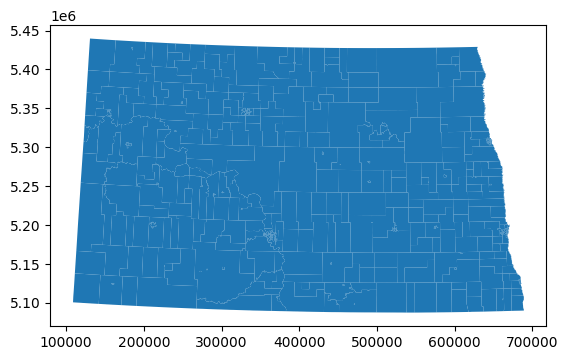

In [57]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()